# EfficientDet Tutorial: inference, eval, and training 



<table align="left"><td>
  <a target="_blank"  href="https://github.com/google/automl/blob/master/efficientdet/tutorial.ipynb">
    <img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on github
  </a>
</td><td>
  <a target="_blank"  href="https://colab.sandbox.google.com/github/google/automl/blob/master/efficientdet/tutorial.ipynb">
    <img width=32px src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
</td></table>

# 0. Install and view graph.

## 0.1 Install package and download source code/image.



In [0]:
%%capture
#@title
import os
import sys
import tensorflow.compat.v1 as tf

# Download source code.
if "efficientdet" not in os.getcwd():
  !git clone --depth 1 https://github.com/google/automl
  os.chdir('automl/efficientdet')
  sys.path.append('.')
  !pip install -r requirements.txt
  !pip install -U 'git+https://github.com/cocodataset/cocoapi.git#subdirectory=PythonAPI'
else:
  !git pull

In [0]:
MODEL = 'efficientdet-d0'  #@param

def download(m):
  if m not in os.listdir():
    !wget https://storage.googleapis.com/cloud-tpu-checkpoints/efficientdet/coco/{m}.tar.gz
    !tar zxf {m}.tar.gz
  ckpt_path = os.path.join(os.getcwd(), m)
  return ckpt_path

# Download checkpoint.
ckpt_path = download(MODEL)
print('Use model in {}'.format(ckpt_path))

# Prepare image and visualization settings.
image_url =  'https://user-images.githubusercontent.com/11736571/77320690-099af300-6d37-11ea-9d86-24f14dc2d540.png'#@param
image_name = 'img.png' #@param
!wget {image_url} -O img.png
import os
img_path = os.path.join(os.getcwd(), 'img.png')

min_score_thresh = 0.35  #@param
max_boxes_to_draw = 200  #@param
line_thickness =   2#@param

import PIL
# Get the largest of height/width and round to 128.
image_size = max(PIL.Image.open(img_path).size)

--2020-06-01 05:07:16--  https://storage.googleapis.com/cloud-tpu-checkpoints/efficientdet/coco/efficientdet-d0.tar.gz
Resolving storage.googleapis.com (storage.googleapis.com)... 173.194.217.128, 2607:f8b0:400c:c05::80
Connecting to storage.googleapis.com (storage.googleapis.com)|173.194.217.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 28994253 (28M) [application/octet-stream]
Saving to: ‘efficientdet-d0.tar.gz’

efficientdet-d0.tar 100%[===================>]  27.65M   164MB/s    in 0.2s    

2020-06-01 05:07:16 (164 MB/s) - ‘efficientdet-d0.tar.gz’ saved [28994253/28994253]

Use model in /content/automl/efficientdet/efficientdet-d0
--2020-06-01 05:07:18--  https://user-images.githubusercontent.com/11736571/77320690-099af300-6d37-11ea-9d86-24f14dc2d540.png
Resolving user-images.githubusercontent.com (user-images.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to user-images.githubusercontent.com (user-images.git

## 0.2 View graph in TensorBoard

In [0]:
!python model_inspect.py --model_name={MODEL} --logdir=logs &> /dev/null
%load_ext tensorboard
%tensorboard --logdir logs

# 1. inference

## 1.1 Benchmark network latency
There are two types of latency:
network latency and end-to-end latency.

*   network latency: from the first conv op to the network class and box prediction.
*   end-to-end latency: from image preprocessing, network, to the final postprocessing to generate a annotated new image.


In [0]:
# benchmaak network latency
!python model_inspect.py --runmode=bm --model_name=efficientdet-d4 --hparams="mixed_precision=true"

# With colab + Tesla T4 GPU, here are the batch size 1 latency summary:
# D0 (AP=33.5):  14.9ms,  FPS = 67.2   (batch size 8 FPS=)
# D1 (AP=39.6):  22.7ms,  FPS = 44.1   (batch size 8 FPS=)
# D2 (AP=43.0):  27.9ms,  FPS = 35.8   (batch size 8 FPS=)
# D3 (AP=45.8):  48.1ms,  FPS = 20.8   (batch size 8 FPS=)
# D4 (AP=49.4):  81.9ms,  FPS = 12.2   (batch size 8 FPS=)

## 1.2 Benchmark end-to-end latency

In [0]:
# Benchmark end-to-end latency (: preprocess + network + posprocess).
#
# With colab + Tesla T4 GPU, here are the batch size 1 latency summary:
# D0 (AP=33.5): 22.7ms,  FPS = 43.1   (batch size 4, FPS=)
# D1 (AP=39.6): 34.3ms,  FPS = 29.2   (batch size 4, FPS=)
# D2 (AP=43.0): 42.5ms,  FPS = 23.5   (batch size 4, FPS=)
# D3 (AP=45.8): 64.8ms,  FPS = 15.4   (batch size 4, FPS=)
# D4 (AP=49.4): 93.7ms,  FPS = 10.7   (batch size 4, FPS=)

m = 'efficientdet-d4'  # @param
batch_size = 1  # @param
m_path = download(m)

saved_model_dir = 'savedmodel'
!rm -rf {saved_model_dir}
!python model_inspect.py --runmode=saved_model --model_name={m} \
  --ckpt_path={m_path} --saved_model_dir={saved_model_dir} \
  --batch_size={batch_size}  --hparams="mixed_precision=true"
!python model_inspect.py --runmode=saved_model_benchmark --model_name={m} \
  --ckpt_path={m_path} --saved_model_dir={saved_model_dir}/{m}_frozen.pb \
  --batch_size={batch_size}  --hparams="mixed_precision=true" --input_image=testdata/img1.jpg


--2020-06-01 05:42:55--  https://storage.googleapis.com/cloud-tpu-checkpoints/efficientdet/coco/efficientdet-d4.tar.gz
Resolving storage.googleapis.com (storage.googleapis.com)... 173.194.216.128, 2607:f8b0:400c:c01::80
Connecting to storage.googleapis.com (storage.googleapis.com)|173.194.216.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 152915674 (146M) [application/octet-stream]
Saving to: ‘efficientdet-d4.tar.gz’

efficientdet-d4.tar 100%[===================>] 145.83M   129MB/s    in 1.1s    

2020-06-01 05:42:57 (129 MB/s) - ‘efficientdet-d4.tar.gz’ saved [152915674/152915674]

2020-06-01 05:43:01.074313: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.1
2020-06-01 05:43:03.448788: I tensorflow/core/platform/profile_utils/cpu_utils.cc:102] CPU Frequency: 2300000000 Hz
2020-06-01 05:43:03.448968: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x1981100 initialized for p

## 1.3 Inference images.

---



In [0]:
# first export a saved model.
saved_model_dir = 'savedmodel'
!rm -rf {saved_model_dir}
!python model_inspect.py --runmode=saved_model --model_name={MODEL} \
  --ckpt_path={ckpt_path} --saved_model_dir={saved_model_dir}

# Then run saved_model_infer to do inference.
# Notably: batch_size, image_size must be the same as when it is exported.
serve_image_out = 'serve_image_out'
!mkdir {serve_image_out}

!python model_inspect.py --runmode=saved_model_infer \
  --saved_model_dir={saved_model_dir} \
  --model_name={MODEL}  --input_image=testdata/img1.jpg  \
  --output_image_dir={serve_image_out} \
  --min_score_thresh={min_score_thresh}  --max_boxes_to_draw={max_boxes_to_draw}

2020-05-31 22:18:29.834258: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.1
2020-05-31 22:18:31.984806: I tensorflow/core/platform/profile_utils/cpu_utils.cc:102] CPU Frequency: 2300000000 Hz
2020-05-31 22:18:31.984976: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x20ff100 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
2020-05-31 22:18:31.985007: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Host, Default Version
2020-05-31 22:18:31.986636: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcuda.so.1
2020-05-31 22:18:32.117308: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2020-05-31 22:18:32.117967: I tensorflow/compiler/xla/servic

In [0]:
from IPython import display
display.display(display.Image(os.path.join(serve_image_out, '0.jpg')))

2020-06-01 05:46:14.071332: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.1
2020-06-01 05:46:16.401257: I tensorflow/core/platform/profile_utils/cpu_utils.cc:102] CPU Frequency: 2300000000 Hz
2020-06-01 05:46:16.401496: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x270f100 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
2020-06-01 05:46:16.401531: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Host, Default Version
2020-06-01 05:46:16.403436: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcuda.so.1
2020-06-01 05:46:16.547796: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2020-06-01 05:46:16.548486: I tensorflow/compiler/xla/servic

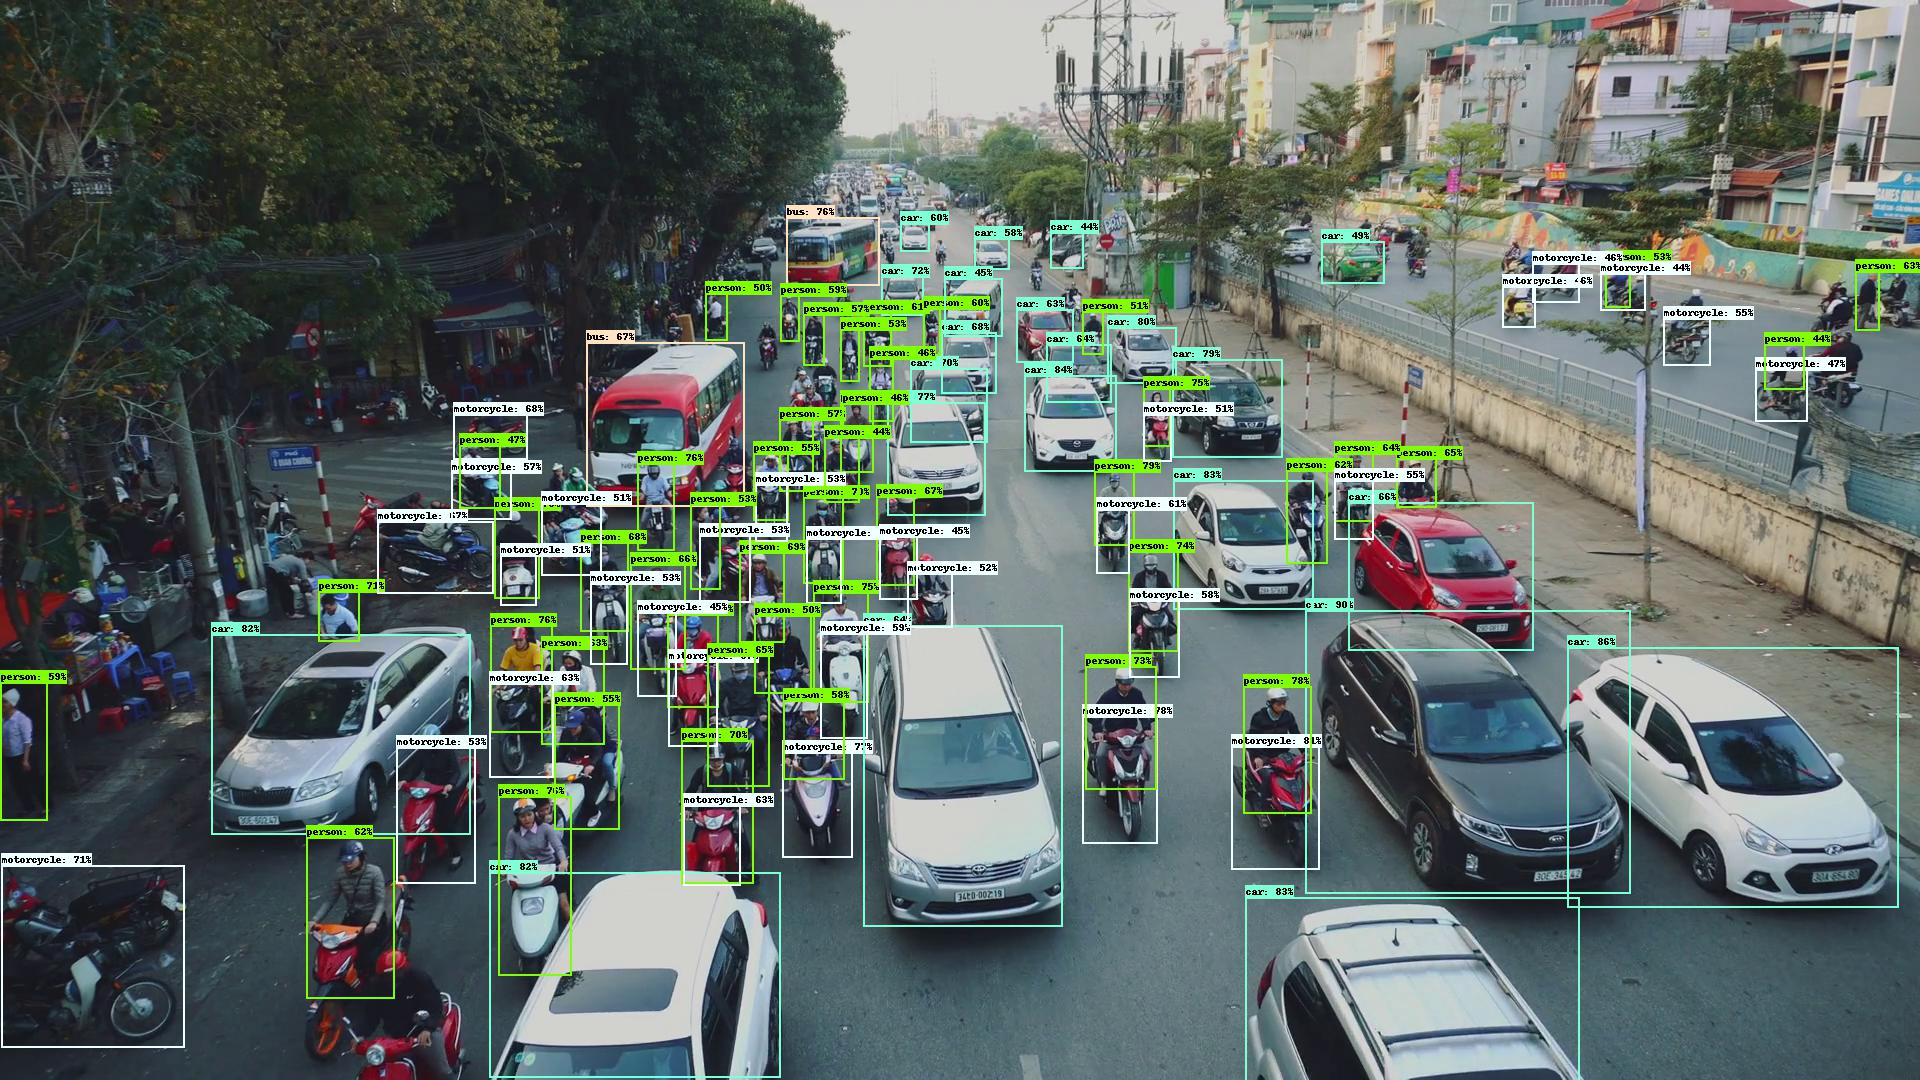

In [0]:
# In case you need to specify different image size or batch size or #boxes, then
# you need to export a new saved model and run the inferernce.

serve_image_out = 'serve_image_out'
!mkdir {serve_image_out}
saved_model_dir = 'savedmodel'
!rm -rf {saved_model_dir}

# Step 1: export model
!python model_inspect.py --runmode=saved_model \
  --model_name=efficientdet-d0 --ckpt_path=efficientdet-d0 \
  --hparams="image_size=1920x1280" --saved_model_dir={saved_model_dir}

# Step 2: do inference with saved model.
!python model_inspect.py --runmode=saved_model_infer \
  --model_name=efficientdet-d0 --saved_model_dir={saved_model_dir} \
  --input_image=img.png --output_image_dir={serve_image_out} \
  --min_score_thresh={min_score_thresh}  --max_boxes_to_draw={max_boxes_to_draw}

from IPython import display
display.display(display.Image(os.path.join(serve_image_out, '0.jpg')))

## 1.4 Inference video

In [0]:
# step 0: download video
video_url = 'https://storage.googleapis.com/cloud-tpu-checkpoints/efficientdet/data/video480p.mov'  # @param
!wget {video_url} -O input.mov

# Step 1: export model
saved_model_dir = 'savedmodel'
!rm -rf {saved_model_dir}

!python model_inspect.py --runmode=saved_model \
  --model_name=efficientdet-d0 --ckpt_path=efficientdet-d0 \
  --saved_model_dir={saved_model_dir} --hparams="mixed_precision=true"

# Step 2: do inference with saved model using saved_model_video
!python model_inspect.py --runmode=saved_model_video \
  --model_name=efficientdet-d0   --ckpt_path=efficientdet-d0 \
  --saved_model_dir={saved_model_dir} --hparams="mixed_precision=true" \
  --input_video=input.mov --output_video=output.mov
# Then you can view the output.mov

--2020-06-01 05:08:08--  https://storage.googleapis.com/cloud-tpu-checkpoints/efficientdet/data/video480p.mov
Resolving storage.googleapis.com (storage.googleapis.com)... 172.217.204.128, 2607:f8b0:400c:c05::80
Connecting to storage.googleapis.com (storage.googleapis.com)|172.217.204.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 18511760 (18M) [application/octet-stream]
Saving to: ‘input.mov’

input.mov           100%[===================>]  17.65M  --.-KB/s    in 0.1s    

2020-06-01 05:08:08 (119 MB/s) - ‘input.mov’ saved [18511760/18511760]

2020-06-01 05:08:10.640913: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.1
2020-06-01 05:08:12.964736: I tensorflow/core/platform/profile_utils/cpu_utils.cc:102] CPU Frequency: 2300000000 Hz
2020-06-01 05:08:12.965102: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x2c41480 initialized for platform Host (this does not guarantee t

# 3. COCO evaluation

## 3.1 COCO evaluation on validation set.

In [0]:
if 'val2017' not in os.listdir():
  !wget http://images.cocodataset.org/zips/val2017.zip
  !wget http://images.cocodataset.org/annotations/annotations_trainval2017.zip
  !unzip -q val2017.zip
  !unzip annotations_trainval2017.zip

  !mkdir tfrecord
  !PYTHONPATH=".:$PYTHONPATH"  python dataset/create_coco_tfrecord.py \
      --image_dir=val2017 \
      --caption_annotations_file=annotations/captions_val2017.json \
      --output_file_prefix=tfrecord/val \
      --num_shards=32

--2020-06-01 03:22:59--  http://images.cocodataset.org/zips/val2017.zip
Resolving images.cocodataset.org (images.cocodataset.org)... 52.216.239.115
Connecting to images.cocodataset.org (images.cocodataset.org)|52.216.239.115|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 815585330 (778M) [application/zip]
Saving to: ‘val2017.zip’

val2017.zip         100%[===================>] 777.80M  95.2MB/s    in 8.1s    

2020-06-01 03:23:07 (96.1 MB/s) - ‘val2017.zip’ saved [815585330/815585330]

--2020-06-01 03:23:08--  http://images.cocodataset.org/annotations/annotations_trainval2017.zip
Resolving images.cocodataset.org (images.cocodataset.org)... 52.216.163.67
Connecting to images.cocodataset.org (images.cocodataset.org)|52.216.163.67|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 252907541 (241M) [application/zip]
Saving to: ‘annotations_trainval2017.zip’

annotations_trainva 100%[===================>] 241.19M  96.2MB/s    in 2.5s    

2020

In [0]:
# Evalute on validation set (takes about 10 mins for efficientdet-d0)
!python main.py --mode=eval  \
    --model_name={MODEL}  --model_dir={ckpt_path}  \
    --val_file_pattern=tfrecord/val*  \
    --val_json_file=annotations/instances_val2017.json

2020-06-01 03:28:25.377482: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.1

W0601 03:28:27.532853 140219029243776 module_wrapper.py:138] From main.py:234: The name tf.estimator.tpu.TPUConfig is deprecated. Please use tf.compat.v1.estimator.tpu.TPUConfig instead.


W0601 03:28:27.533198 140219029243776 module_wrapper.py:138] From main.py:239: The name tf.estimator.tpu.InputPipelineConfig is deprecated. Please use tf.compat.v1.estimator.tpu.InputPipelineConfig instead.


W0601 03:28:27.533394 140219029243776 module_wrapper.py:138] From main.py:247: The name tf.estimator.tpu.RunConfig is deprecated. Please use tf.compat.v1.estimator.tpu.RunConfig instead.

I0601 03:28:27.533618 140219029243776 main.py:262] {'name': 'efficientdet-d0', 'act_type': 'swish', 'image_size': (512, 512), 'target_size': None, 'input_rand_hflip': True, 'train_scale_min': 0.1, 'train_scale_max': 2.0, 'autoaugment_policy': None, 'use_augmix': Fals

## 3.2 COCO evaluation on test-dev.

In [0]:
# Eval on test-dev is slow (~40 mins), please be cautious. 
RUN_EXPENSIVE_TEST_DEV_EVAL = True  #@param

if RUN_EXPENSIVE_TEST_DEV_EVAL == True:
  !rm *.zip *.tar tfrecord/ val2017/   # Cleanup disk space
  # Download and convert test-dev data.
  if "test2017" not in os.listdir():
    !wget http://images.cocodataset.org/zips/test2017.zip
    !unzip -q test2017.zip
    !wget http://images.cocodataset.org/annotations/image_info_test2017.zip
    !unzip image_info_test2017.zip

    !mkdir tfrecord
    !PYTHONPATH=".:$PYTHONPATH"  python dataset/create_coco_tfrecord.py \
          --image_dir=test2017 \
          --image_info_file=annotations/image_info_test-dev2017.json \
          --output_file_prefix=tfrecord/testdev \
          --num_shards=32

  # Evalute on validation set: non-empty testdev_dir is the key pararmeter.
  # Also, test-dev has 20288 images rather than val 5000 images.
  !mkdir testdev_output
  !python main.py --mode=eval  \
      --model_name={MODEL}  --model_dir={ckpt_path}  \
      --val_file_pattern=tfrecord/testdev*  \
      --eval_batch_size=8  --eval_samples=20288 \
      --testdev_dir='testdev_output'
  !rm -rf test2017  # delete images to release disk space.
  # Now you can submit testdev_output/detections_test-dev2017_test_results.json to
  # coco server: https://competitions.codalab.org/competitions/20794#participate

# 4. Training EfficientDets on PASCAL.

## 4.1 Prepare data

In [0]:
# Get pascal voc 2012 trainval data
import os
if 'VOCdevkit' not in os.listdir():
  !wget http://host.robots.ox.ac.uk/pascal/VOC/voc2012/VOCtrainval_11-May-2012.tar
  !tar xf VOCtrainval_11-May-2012.tar

  !mkdir tfrecord
  !PYTHONPATH=".:$PYTHONPATH"  python dataset/create_pascal_tfrecord.py  \
    --data_dir=VOCdevkit --year=VOC2012  --output_path=tfrecord/pascal

# Pascal has 5717 train images with 100 shards epoch, here we use a single shard
# for demo, but users should use all shards pascal-*-of-00100.tfrecord.
file_pattern = 'pascal-00000-of-00100.tfrecord'  # @param
images_per_epoch = 57 * len(tf.io.gfile.glob('tfrecord/' + file_pattern))
images_per_epoch = images_per_epoch // 8 * 8  # round to 64.
print('images_per_epoch = {}'.format(images_per_epoch))

--2020-06-01 05:10:36--  http://host.robots.ox.ac.uk/pascal/VOC/voc2012/VOCtrainval_11-May-2012.tar
Resolving host.robots.ox.ac.uk (host.robots.ox.ac.uk)... 129.67.94.152
Connecting to host.robots.ox.ac.uk (host.robots.ox.ac.uk)|129.67.94.152|:80... connected.
HTTP request sent, awaiting response... Read error (Connection reset by peer) in headers.
Retrying.

--2020-06-01 05:11:57--  (try: 2)  http://host.robots.ox.ac.uk/pascal/VOC/voc2012/VOCtrainval_11-May-2012.tar
Connecting to host.robots.ox.ac.uk (host.robots.ox.ac.uk)|129.67.94.152|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1999639040 (1.9G) [application/x-tar]
Saving to: ‘VOCtrainval_11-May-2012.tar’

VOCtrainval_11-May- 100%[===================>]   1.86G  13.7MB/s    in 2m 22s  

2020-06-01 05:20:26 (13.5 MB/s) - ‘VOCtrainval_11-May-2012.tar’ saved [1999639040/1999639040]

2020-06-01 05:21:21.622800: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library

## 4.2 Train Pascal VOC 2012 from ImageNet checkpoint for Backbone.

In [0]:
# Train efficientdet from scratch with backbone checkpoint.
backbone_name = {
    'efficientdet-d0': 'efficientnet-b0',
    'efficientdet-d1': 'efficientnet-b1',
    'efficientdet-d2': 'efficientnet-b2',
    'efficientdet-d3': 'efficientnet-b3',
    'efficientdet-d4': 'efficientnet-b4',
    'efficientdet-d5': 'efficientnet-b5',
    'efficientdet-d6': 'efficientnet-b6',
    'efficientdet-d7': 'efficientnet-b6',
}[MODEL]


# generating train tfrecord is large, so we skip the execution here.
import os
if backbone_name not in os.listdir():
  !wget https://storage.googleapis.com/cloud-tpu-checkpoints/efficientnet/ckptsaug/{backbone_name}.tar.gz
  !tar xf {backbone_name}.tar.gz

!mkdir /tmp/model_dir
# key option: use --backbone_ckpt rather than --ckpt.
# Don't use ema since we only train a few steps.
!python main.py --mode=train_and_eval \
    --train_file_pattern=tfrecord/{file_pattern} \
    --val_file_pattern=tfrecord/{file_pattern} \
    --model_name={MODEL} \
    --model_dir=/tmp/model_dir/{MODEL}-scratch  \
    --backbone_ckpt={backbone_name} \
    --train_batch_size=4 \
    --eval_batch_size=4 --eval_samples={images_per_epoch}  \
    --num_examples_per_epoch={images_per_epoch}  --num_epochs=1  \
    --hparams="num_classes=20,moving_average_decay=0,mixed_precision=true"

--2020-06-01 05:36:57--  https://storage.googleapis.com/cloud-tpu-checkpoints/efficientnet/ckptsaug/efficientnet-b0.tar.gz
Resolving storage.googleapis.com (storage.googleapis.com)... 173.194.216.128, 2607:f8b0:400c:c13::80
Connecting to storage.googleapis.com (storage.googleapis.com)|173.194.216.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 39302973 (37M) [application/gzip]
Saving to: ‘efficientnet-b0.tar.gz’

efficientnet-b0.tar 100%[===================>]  37.48M   162MB/s    in 0.2s    

2020-06-01 05:36:58 (162 MB/s) - ‘efficientnet-b0.tar.gz’ saved [39302973/39302973]

2020-06-01 05:37:00.448456: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.1

W0601 05:37:02.781105 140460941842304 module_wrapper.py:138] From main.py:234: The name tf.estimator.tpu.TPUConfig is deprecated. Please use tf.compat.v1.estimator.tpu.TPUConfig instead.


W0601 05:37:02.781442 140460941842304 module_wrappe

## 4.3 Train Pascal VOC 2012 from COCO checkpoint for the whole net.

In [0]:
# generating train tfrecord is large, so we skip the execution here.
import os
if MODEL not in os.listdir():
  !wget https://storage.googleapis.com/cloud-tpu-checkpoints/efficientdet/coco/{MODEL}.tar.gz
  !tar xf {MODEL}.tar.gz

!mkdir /tmp/model_dir/
# key option: use --ckpt rather than --backbone_ckpt.
!python main.py --mode=train_and_eval \
    --train_file_pattern=tfrecord/{file_pattern} \
    --val_file_pattern=tfrecord/{file_pattern} \
    --model_name={MODEL} \
    --model_dir=/tmp/model_dir/{MODEL}-finetune \
    --ckpt={MODEL} \
    --train_batch_size=8 \
    --eval_batch_size=8 --eval_samples={images_per_epoch}  \
    --num_examples_per_epoch={images_per_epoch}  --num_epochs=1  \
    --hparams="num_classes=20,moving_average_decay=0,mixed_precision=true"

mkdir: cannot create directory ‘/tmp/model_dir/’: File exists
2020-06-01 05:38:43.365099: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.1

W0601 05:38:45.587865 140233166403456 module_wrapper.py:138] From main.py:234: The name tf.estimator.tpu.TPUConfig is deprecated. Please use tf.compat.v1.estimator.tpu.TPUConfig instead.


W0601 05:38:45.588135 140233166403456 module_wrapper.py:138] From main.py:239: The name tf.estimator.tpu.InputPipelineConfig is deprecated. Please use tf.compat.v1.estimator.tpu.InputPipelineConfig instead.


W0601 05:38:45.588366 140233166403456 module_wrapper.py:138] From main.py:247: The name tf.estimator.tpu.RunConfig is deprecated. Please use tf.compat.v1.estimator.tpu.RunConfig instead.

I0601 05:38:45.588604 140233166403456 main.py:262] {'name': 'efficientdet-d0', 'act_type': 'swish', 'image_size': (512, 512), 'target_size': None, 'input_rand_hflip': True, 'train_scale_min': 0.1, 'train_s

## 4.4 View tensorboard for loss and accuracy.


In [0]:
%load_ext tensorboard
%tensorboard --logdir /tmp/model_dir/
# Notably, this is just a demo with almost zero accuracy due to very limited
# training steps, but we can see finetuning has smaller loss than training
# from scratch at the begining.